In [8]:
import numpy as np
from lxml import objectify
import os
import torch
import matplotlib.pyplot as plt

from PIL import Image
import torchvision
import torch
from torchvision.io import read_image
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import v2 as T

In [2]:
class HRSC2016(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, imageset='train'):
        self.root = root
        self.transforms = transforms

        with open(os.path.join(root, "ImageSets", f'{imageset}.txt'), 'r') as f:
            required_imgs = set(f.read().split())

        self.imgs = list(filter(lambda x: x.split('.')[0] in required_imgs, sorted(os.listdir(os.path.join(root, "AllImages")))))
        self.annots = list(filter(lambda x: x.split('.')[0] in required_imgs, sorted(os.listdir(os.path.join(root, "Annotations")))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "AllImages", self.imgs[idx])
        annot_path = os.path.join(self.root, "Annotations", self.annots[idx])
        
        img = F.pil_to_tensor(Image.open(img_path))
        with open(annot_path, 'rb') as f:
            annot_root = objectify.fromstring(f.read())

        try:
            num_obj = len(annot_root.object)
        except:
            num_obj = 0
        
        bbs = []
        if num_obj > 0:
            for obj in annot_root.object:
                bbox_xml = obj.bndbox
                bbox = [int(bbox_xml.xmin), int(bbox_xml.ymin), int(bbox_xml.xmax), int(bbox_xml.ymax)]
                bbox = torch.tensor(bbox)
                bbs.append(bbox)

            bboxes = torch.stack(bbs)
            areas = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
            
            bboxes = tv_tensors.BoundingBoxes(bboxes, format='XYXY', canvas_size=F.get_size(img))
            labels = torch.ones((num_obj,), dtype=torch.int64)
            iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        else:
            bboxes = tv_tensors.BoundingBoxes(torch.zeros((0,4),dtype=torch.float32), format='XYXY', canvas_size=F.get_size(img))
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,))
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        
        img = tv_tensors.Image(img)
        target = dict()
        target['boxes'] = bboxes
        target['labels'] = labels
        target['image_id'] = idx
        target['area'] = areas
        target['iscrowd'] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
dataset = HRSC2016('/kaggle/input/hrsc2016-ms-dataset', imageset='trainval')

len(dataset)

1070

In [4]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [5]:
from engine import train_one_epoch, evaluate
import utils

In [58]:
transforms = []
transforms.append(T.RandomHorizontalFlip(0.5))
transforms.append(T.ToDtype(torch.float, scale=True))
#transforms.append(T.RandomResizedCrop(size=(224, 224), antialias=True))
transforms.append(T.ColorJitter())
transforms.append(T.ToPureTensor())

train_dataset = HRSC2016('/kaggle/input/hrsc2016-ms-dataset', imageset='trainval',
                         transforms=T.Compose(transforms))
test_dataset = HRSC2016('/kaggle/input/hrsc2016-ms-dataset', imageset='test',
                        transforms=T.ToDtype(torch.float, scale=True))

In [59]:
batch_size=4
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=utils.collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=utils.collate_fn
)

In [60]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 2  # ship + background
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
pass

In [40]:
from torchvision.models.detection import FCOS
from torchvision.models.detection.rpn import AnchorGenerator

model = torchvision.models.detection.fcos_resnet50_fpn(weights='DEFAULT')
backbone = model.backbone

model = FCOS(backbone, num_classes=2)
model.to(device)
pass

In [61]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.01
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [62]:
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    
    lr_scheduler.step()

Epoch: [0]  [  0/268]  eta: 0:02:36  lr: 0.000047  loss: 1.1768 (1.1768)  loss_classifier: 0.5480 (0.5480)  loss_box_reg: 0.2533 (0.2533)  loss_objectness: 0.3137 (0.3137)  loss_rpn_box_reg: 0.0617 (0.0617)  time: 0.5848  data: 0.0420  max mem: 14025
Epoch: [0]  [ 10/268]  eta: 0:02:31  lr: 0.000422  loss: 1.0107 (1.1864)  loss_classifier: 0.5134 (0.5067)  loss_box_reg: 0.2004 (0.2398)  loss_objectness: 0.2717 (0.3872)  loss_rpn_box_reg: 0.0475 (0.0528)  time: 0.5889  data: 0.0366  max mem: 14025
Epoch: [0]  [ 20/268]  eta: 0:02:24  lr: 0.000796  loss: 0.9209 (1.1236)  loss_classifier: 0.4286 (0.4435)  loss_box_reg: 0.2004 (0.2465)  loss_objectness: 0.2078 (0.3766)  loss_rpn_box_reg: 0.0386 (0.0570)  time: 0.5817  data: 0.0353  max mem: 14025
Epoch: [0]  [ 30/268]  eta: 0:02:19  lr: 0.001170  loss: 0.7336 (1.0095)  loss_classifier: 0.3202 (0.3933)  loss_box_reg: 0.2497 (0.2590)  loss_objectness: 0.1098 (0.3041)  loss_rpn_box_reg: 0.0268 (0.0530)  time: 0.5872  data: 0.0355  max mem: 14

In [64]:
model.eval()
evaluate(model, test_loader, device=device)

creating index...
index created!
Test:  [  0/153]  eta: 0:00:40  model_time: 0.2263 (0.2263)  evaluator_time: 0.0055 (0.0055)  time: 0.2649  data: 0.0261  max mem: 14025
Test:  [100/153]  eta: 0:00:15  model_time: 0.2344 (0.2390)  evaluator_time: 0.0077 (0.0125)  time: 0.2971  data: 0.0300  max mem: 14025
Test:  [152/153]  eta: 0:00:00  model_time: 0.2352 (0.2392)  evaluator_time: 0.0107 (0.0122)  time: 0.2862  data: 0.0319  max mem: 14025
Test: Total time: 0:00:44 (0.2934 s / it)
Averaged stats: model_time: 0.2352 (0.2392)  evaluator_time: 0.0107 (0.0122)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=

## Some tests

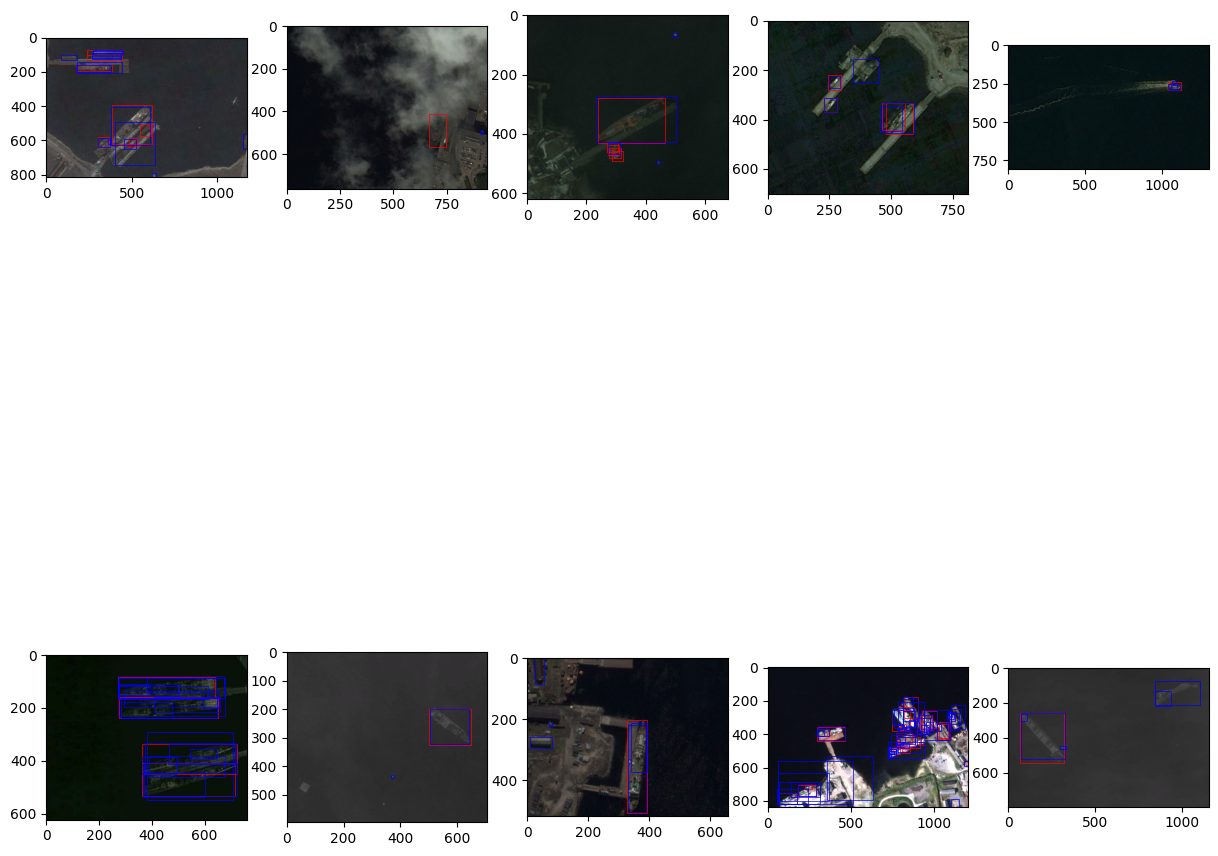

In [65]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(2, 5)
axes = axes.flatten()

indices = np.random.randint(len(test_dataset), size=10)

for idx, num in enumerate(indices):
    ax = axes[idx]
    
    im = test_dataset[num][0]
    true = test_dataset[num][1]['boxes']
    im = np.array(im)
    im = np.moveaxis(im, 0, -1)
    
    ax.imshow(im)
    
    for box in true:
        ax.add_patch(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=0.5,edgecolor='r',facecolor='none'))
    
    model.eval()
    
    with torch.no_grad():
        inp_im = test_dataset[num][0][None, :, :, :].to(device)
        pred = model(inp_im)
        pred_boxes = pred[0]['boxes']
    
    for box in pred_boxes:
        box=box.cpu()
        ax.add_patch(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=0.5,edgecolor='b',facecolor='none'))

fig.set_size_inches(15, 15)


In [66]:
torch.save(model.state_dict(), "/kaggle/working/fasterrcnn_aug.model")